In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

Visualization

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

spark.read.csv("Branches.csv", header = True).createOrReplaceTempView("Branches")
spark.read.csv("Games.csv", header = True).createOrReplaceTempView("Games")
spark.read.csv("Genres.csv", header = True).createOrReplaceTempView("Genres")
spark.read.csv("Platforms.csv", header = True).createOrReplaceTempView("Platforms")
spark.read.csv("Staffs.csv", header = True).createOrReplaceTempView("Staffs")
spark.read.csv("TransactionDetail.csv", header = True).createOrReplaceTempView("TransactionDetail")
spark.read.csv("TransactionHeader.csv", header = True).createOrReplaceTempView("TransactionHeader")


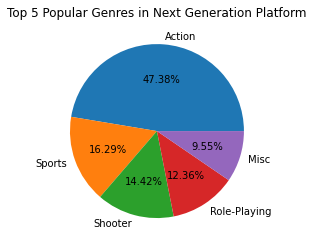

In [ ]:
#a. Show the percentage of games released by genres that is in the next generation platform (“WiiU”,”PS4”,”XOne”) using pie plot.

soal1 = spark.sql("""
        SELECT GenreName As Name, COUNT(ga.GameId) As Count
        FROM Genres ge 
        JOIN Games ga ON ge.GenreId = ga.GenreId
        JOIN Platforms p ON p.PlatformId = ga.PlatformId
        WHERE PlatformName = 'WiiU' OR PlatformName = 'PS4' OR PlatformName = 'XOne'
        GROUP BY Name
        ORDER BY Count DESC
        LIMIT 5
""").toPandas()

plt.pie(soal1["Count"], labels = soal1["Name"], autopct = "%.2f%%")
plt.title("Top 5 Popular Genres in Next Generation Platform")
plt.show()

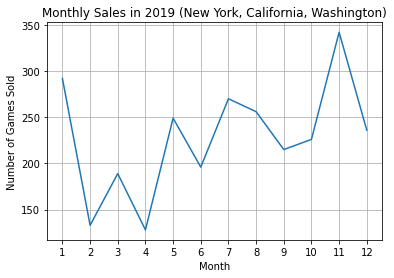

In [ ]:
# b. Show the total number of games sold per month in 2019 in which the transaction is done in 
# “New York”, “California”, or “Washington” branch region using line plot.

soal2 = spark.sql("""
        SELECT SUM(td.Quantity) AS Count, MONTH(th.TransactionDate) AS Month 
        FROM TransactionDetail td
        JOIN TransactionHeader th ON th.TransactionId = td.TransactionId
        JOIN Branches b ON b.BranchId = th.BranchId
        WHERE YEAR(th.TransactionDate) = 2019 AND b.BranchRegion = "New York" OR b.BranchRegion = "California" OR b.BranchRegion = "Washington" 
        GROUP BY Month
        ORDER BY Month
""").toPandas()

plt.plot(soal2["Month"], soal2["Count"])
plt.title("Monthly Sales in 2019 (New York, California, Washington)")
plt.xlabel("Month")
plt.ylabel("Number of Games Sold")
plt.xticks(range(1,13))
plt.grid()
plt.show()

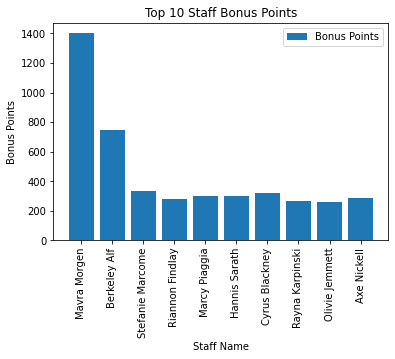

In [ ]:
# c. Show bonus points for top 10 staff who handled the most number of transactions that does not occur in “New York” or “Alabama” branch using bar plot. 
# The bonus points are earned based on the following condition: 
# > 400	Games Sold Quantity * 3
# > 350	Games Sold Quantity * 2
# <= 350	Games Sold Quantity

soal3 = spark.sql("""
        SELECT StaffName AS Name,
               CASE
                    WHEN SUM(Quantity) > 400 THEN SUM(Quantity)*3
                    WHEN SUM(Quantity) > 350 THEN SUM(Quantity)*2
                    WHEN SUM(Quantity) <= 350 THEN SUM(Quantity)
               END AS Bonus,
               COUNT(DISTINCT th.TransactionId) AS Transaction
        FROM TransactionDetail td
        JOIN TransactionHeader th ON th.TransactionId = td.TransactionID
        JOIN Branches b ON b.BranchId = th.BranchId
        JOIN Staffs s ON s.StaffId = th.StaffId 
        WHERE BranchRegion NOT LIKE 'New York' AND BranchRegion NOT LIKE 'Alabama'
        GROUP BY StaffName
        ORDER BY Transaction DESC
        LIMIT 10
""").toPandas()

plt.bar(soal3["Name"], soal3["Bonus"])
plt.title("Top 10 Staff Bonus Points")
plt.xlabel("Staff Name")
plt.ylabel("Bonus Points")
plt.xticks(rotation=90)
plt.legend(['Bonus Points'])
plt.show()

Classification

In [ ]:
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1. Load Data
train = spark.read.option("inferSchema", "true").csv("GameTrain.csv", header = True)
test = spark.read.option("inferSchema", "true").csv("GameTest.csv", header = True)

# 2. Select Features
train = train.select("Rating", "Popular", "SalesPerWeek", "Overall")
test = test.select("Rating", "Popular", "SalesPerWeek", "Overall")

# 3. Data Preprocessing
train = train.na.drop()
test = test.na.drop()

# 4. Transform Data
train = train.withColumn("Rating", when(train["Rating"] == "High", 0).when(train["Rating"] == "Average", 1).otherwise(2))
train = train.withColumn("Popular", when(train["Popular"] == "Yes", 0).otherwise(1))
train = train.withColumn("Overall", when(train["Overall"] == "Good", 0).otherwise(1))

test = test.withColumn("Rating", when(test["Rating"] == "High", 0).when(test["Rating"] == "Average", 1).otherwise(2))
test = test.withColumn("Popular", when(test["Popular"] == "Yes", 0).otherwise(1))
test = test.withColumn("Overall", when(test["Overall"] == "Good", 0).otherwise(1))

# 5. Normalization
col = train.columns
col.remove("Overall")
train = VectorAssembler(inputCols=col, outputCol="Features").transform(train)
test = VectorAssembler(inputCols=col, outputCol="Features").transform(test)

scaler = StandardScaler(inputCol="Features", outputCol="Normalized")
train = scaler.fit(train).transform(train)
test = scaler.fit(test).transform(test)

# 6. Generate Model
model = LogisticRegression(featuresCol="Normalized", labelCol="Overall", maxIter=20).fit(train)

prediction = model.transform(test)

# 7. Model Testing dan Evaluation
eval = BinaryClassificationEvaluator(labelCol="Overall")
print(eval.evaluate(prediction) * 100)

train.show(50)
test.show(50)

96.31594741859179
+------+-------+------------+-------+--------------+--------------------+
|Rating|Popular|SalesPerWeek|Overall|      Features|          Normalized|
+------+-------+------------+-------+--------------+--------------------+
|     0|      1|          35|      0|[0.0,1.0,35.0]|[0.0,2.0000072509...|
|     0|      1|          27|      0|[0.0,1.0,27.0]|[0.0,2.0000072509...|
|     0|      0|          27|      0|[0.0,0.0,27.0]|[0.0,0.0,2.284979...|
|     0|      0|          24|      0|[0.0,0.0,24.0]|[0.0,0.0,2.031092...|
|     0|      0|          18|      0|[0.0,0.0,18.0]|[0.0,0.0,1.523319...|
|     1|      0|          25|      0|[1.0,0.0,25.0]|[1.32411294158431...|
|     0|      1|          12|      1|[0.0,1.0,12.0]|[0.0,2.0000072509...|
|     1|      1|          15|      1|[1.0,1.0,15.0]|[1.32411294158431...|
|     0|      0|          38|      0|[0.0,0.0,38.0]|[0.0,0.0,3.215896...|
|     1|      1|          48|      0|[1.0,1.0,48.0]|[1.32411294158431...|
|     0|      1|    